### Распределение эмбеддингов текстов. 
Энкодер: e5-base-v2

In [1]:
SEED = 42
ENCODER = "intfloat/e5-base-v2"
MAX_HUMAN_SAMPLES = 10000

MAX_VIS_SAMPLES = 2000

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.covariance import LedoitWolf
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_recall_curve
from sklearn.decomposition import PCA
from scipy.special import softmax
from random import sample
from scipy.stats import skew, kurtosis
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [3]:
# https://huggingface.co/intfloat/e5-base-v2

def average_pool(last_hidden_states, attention_mask):
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

    
def get_embeddings(tokenizer, model, df, batch_size=16, device=None):
    if device is None:
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

    model.to(device)
    model.eval()
    all_embeddings = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = list(map(lambda text: "passage: " + text, df[i:i + batch_size].tolist()))
        encoded_input = tokenizer(
            batch_texts,
            max_length=512,
            padding=True,
            truncation=True,
            return_tensors='pt'
        )

        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

        with torch.no_grad():
            model_output = model(**encoded_input)
            embeddings = average_pool(model_output.last_hidden_state, encoded_input['attention_mask'])
        
        all_embeddings.append(embeddings.cpu())

        if device.type == "mps":
            torch.mps.empty_cache()

    all_embeddings = torch.cat(all_embeddings, dim=0)
    return all_embeddings

In [4]:
sns.set(style="whitegrid")

def subsample(X_h, X_ai, max_samples):
    idx_h = list(range(len(X_h)))
    idx_ai = list(range(len(X_ai)))

    if len(idx_h) > max_samples // 2:
        idx_h = sample(idx_h, max_samples // 2)
    if len(idx_ai) > max_samples // 2:
        idx_ai = sample(idx_ai, max_samples // 2)

    X = np.vstack([X_h[idx_h], X_ai[idx_ai]])
    y = np.concatenate([np.zeros(len(idx_h)), np.ones(len(idx_ai))])

    return X, y


def plot_mahalanobis_distributions(scores_human, scores_ai, name):
    plt.figure(figsize=(8, 5))

    all_scores = np.concatenate([scores_human, scores_ai])
    bins = np.histogram_bin_edges(all_scores, bins="auto")

    plt.hist(scores_human, bins=bins, density=True, alpha=0.6, label="Человек")
    plt.hist(scores_ai, bins=bins, density=True, alpha=0.6, label="ИИ")

    plt.title(f"Распределение расстояния Махаланобиса (набор '{name}')")
    plt.xlabel("Квадрат расстояния Махаланобиса")
    plt.ylabel("Плотность")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    plt.show()


def plot_roc_curve(y_true, scores, roc_auc, name):
    fpr, tpr, _ = roc_curve(y_true, scores)
    
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate TPR")
    plt.title(f"ROC-кривая ('{name}')")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    plt.show()


def plot_pca_projection(X_human, X_ai, name):
    X, y = subsample(X_human, X_ai, MAX_VIS_SAMPLES)
    X_2d = PCA(n_components=2, random_state=SEED).fit_transform(X)

    plt.figure(figsize=(8, 5))
    scatter = sns.scatterplot(
        x=X_2d[:, 0], y=X_2d[:, 1],
        hue=y, palette={0: "blue", 1: "orange"},
        alpha=0.5, s=35
    )
    plt.title(f"Проекция PCA (dataset '{name}')")

    handles, _ = scatter.get_legend_handles_labels()
    plt.legend(handles=handles, labels=["Человек", "ИИ"])
    plt.tight_layout()
    
    plt.show()


def print_header(title, char="="):
    print(f"\n{char * 100}")
    print(title)
    print(f"{char * 100}")


def print_subheader(title):
    print(f"\n--- {title} ---")


def print_kv(key, value, width=35):
    print(f"{key:<{width}}: {value}")


def covariance_spectrum(cov, top_k=100):
    C = cov.covariance_
    
    eigvals = np.linalg.eigvalsh(C)
    eigvals = eigvals[::-1]
    
    explained = eigvals / eigvals.sum()
    cumulative = np.cumsum(explained)

    fig, ax = plt.subplots(2, 1, figsize=(8, 8))

    ax[0].bar(range(1, top_k + 1), explained[:top_k])
    ax[0].set_title("Объясненная дисперсия (первые компоненты)")
    ax[0].set_xlabel("Номер компоненты")
    ax[0].set_ylabel("Доля объясненной дисперсии")

    ax[1].plot(range(1, top_k + 1), cumulative[:top_k], marker="o")
    ax[1].axhline(0.9, color="r", linestyle="--", label="90%")
    ax[1].axhline(0.95, color="g", linestyle="--", label="95%")
    ax[1].set_title("Накопленная объясненная дисперсия")
    ax[1].set_xlabel("Число компонент")
    ax[1].set_ylabel("Накопленная доля дисперсии")
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    

def print_mahalanobis_stats(scores, label, width=50, precision=4):
    stats = {
        "Среднее": scores.mean(),
        "Стд. отклонение": scores.std(),
        "Асимметрия": skew(scores),
        "Эксцесс": kurtosis(scores),
        "95% квантиль": np.quantile(scores, 0.95),
        "99% квантиль": np.quantile(scores, 0.99),
    }
    
    print(f"Статистики расстояния Махаланобиса ({label})")
    print("=" * width)
    for k, v in stats.items():
        print(f"{k:<18s} | {v:>{width-22}.{precision}f}")
    print("=" * width)
    print("")


def print_norm_stats(X, precision=4):
    norms = np.linalg.norm(X, axis=1)
    
    stats = {
        "Среднее значение нормы": norms.mean(),
        "Стандартное отклонение": norms.std(),
    }
        
    print("Статистики норм векторов")
    print("=" * 32)
    for k, v in stats.items():
        print(f"{k:<24s}: {v:.{precision}f}")
    print("=" * 32)
    print("")

In [5]:
human_df = (
    pd.read_csv("../datasets/human_essays.csv", encoding="utf-8")
    .assign(label=0)[["text", "label"]]
    .reset_index(drop=True)
)

if MAX_HUMAN_SAMPLES is not None:
    human_df = human_df[:MAX_HUMAN_SAMPLES]

print(f"Живых текстов: {len(human_df)}")

Живых текстов: 10000


In [6]:
filenames = {
    "Mistral 7B 1": "../datasets/mistral_essays_1.csv",
    "Mistral 7B 2": "../datasets/mistral_essays_2.csv",
    "Mistral 7B 3": "../datasets/mistral_essays_3.csv",
    "Mistral 7B 4": "../datasets/mistral_essays_4.csv",
    "Mistral 7B 5": "../datasets/mistral_essays_5.csv",
    "Llama 3 13B 1": "../datasets/llama_essays_1.csv",
    "Llama 3 13B 2": "../datasets/llama_essays_2.csv",
    "Llama 3 13B 3": "../datasets/llama_essays_3.csv",
    "Llama 3 13B 4": "../datasets/llama_essays_4.csv",
    "Llama 3 13B 5": "../datasets/llama_essays_5.csv",
    "DeepSeek V3.2 1": "../datasets/deepseek_essays_1.csv",
    "DeepSeek V3.2 2": "../datasets/deepseek_essays_2.csv",
    "DeepSeek V3.2 3": "../datasets/deepseek_essays_3.csv",
    "DeepSeek V3.2 4": "../datasets/deepseek_essays_4.csv",
    "DeepSeek V3.2 5": "../datasets/deepseek_essays_5.csv",
    "ChatGPT 1": "../datasets/chatgpt_essays_1.csv",
    "ChatGPT 2": "../datasets/chatgpt_essays_2.csv",
    "ChatGPT 3": "../datasets/chatgpt_essays_3.csv",
    "ChatGPT 4": "../datasets/chatgpt_essays_4.csv",
    "ChatGPT 5": "../datasets/chatgpt_essays_5.csv",
}

ai_datasets = {}
for name, fn in filenames.items():
    df = pd.read_csv(fn, encoding="utf-8").assign(label=1)[["text", "label"]].reset_index(drop=True)
    ai_datasets[name] = df
    print(f"Загружен датасет '{name}'. {len(df)} записей")

Загружен датасет 'Mistral 7B 1'. 1500 записей
Загружен датасет 'Mistral 7B 2'. 1500 записей
Загружен датасет 'Mistral 7B 3'. 1500 записей
Загружен датасет 'Mistral 7B 4'. 1500 записей
Загружен датасет 'Mistral 7B 5'. 1500 записей
Загружен датасет 'Llama 3 13B 1'. 999 записей
Загружен датасет 'Llama 3 13B 2'. 1000 записей
Загружен датасет 'Llama 3 13B 3'. 994 записей
Загружен датасет 'Llama 3 13B 4'. 997 записей
Загружен датасет 'Llama 3 13B 5'. 999 записей
Загружен датасет 'DeepSeek V3.2 1'. 3000 записей
Загружен датасет 'DeepSeek V3.2 2'. 3000 записей
Загружен датасет 'DeepSeek V3.2 3'. 2999 записей
Загружен датасет 'DeepSeek V3.2 4'. 3000 записей
Загружен датасет 'DeepSeek V3.2 5'. 2500 записей
Загружен датасет 'ChatGPT 1'. 2000 записей
Загружен датасет 'ChatGPT 2'. 2000 записей
Загружен датасет 'ChatGPT 3'. 2000 записей
Загружен датасет 'ChatGPT 4'. 2000 записей
Загружен датасет 'ChatGPT 5'. 2000 записей



ENCODER: intfloat/e5-base-v2


100%|█████████████████████████████████████████| 625/625 [09:02<00:00,  1.15it/s]


Статистики норм векторов
Среднее значение нормы  : 11.1707
Стандартное отклонение  : 0.3384

Эмбеддинги живых текстов (train)   : 7000
Эмбеддинги живых текстов (test)    : 3000


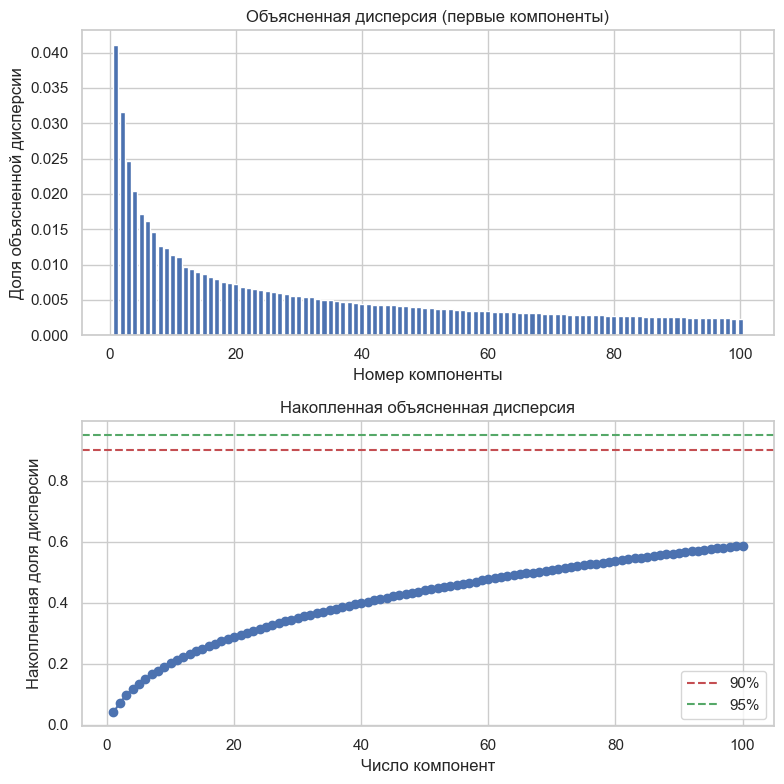


Набор: Mistral 7B 1
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [01:20<00:00,  1.17it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     723.3742
Стд. отклонение    |                     128.1998
Асимметрия         |                       0.6907
Эксцесс            |                       0.8598
95% квантиль       |                     947.7775
99% квантиль       |                    1118.6089

Статистики расстояния Махаланобиса (ии)
Среднее            |                     833.6914
Стд. отклонение    |                     151.8437
Асимметрия         |                       0.8004
Эксцесс            |                       1.2151
95% квантиль       |                    1113.7856
99% квантиль       |                    1257.3374

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.7152


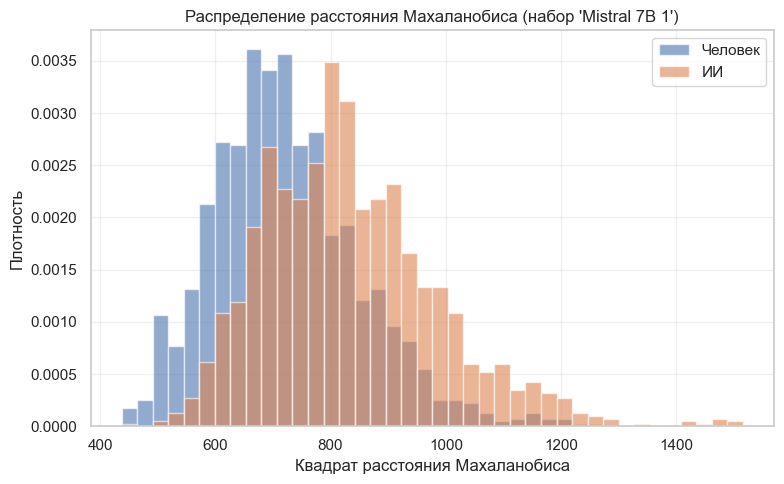

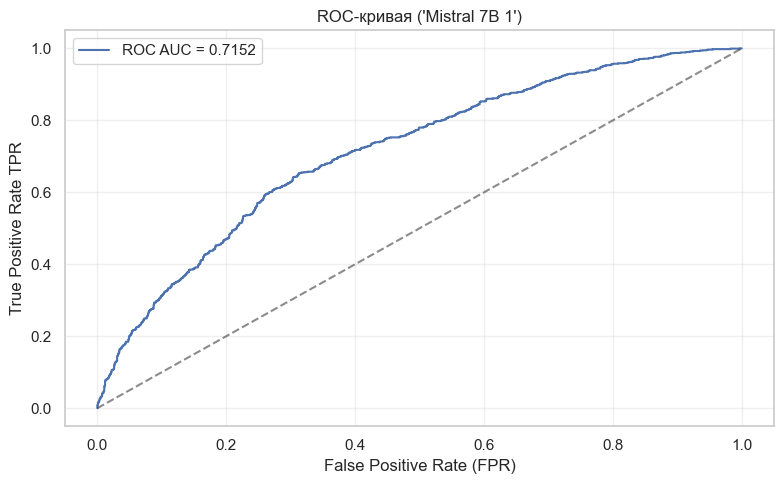

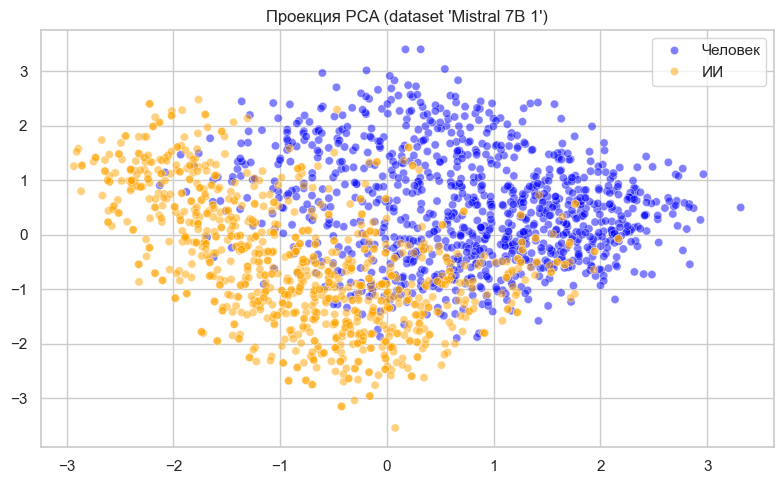


Набор: Mistral 7B 2
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [01:05<00:00,  1.43it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     723.3742
Стд. отклонение    |                     128.1998
Асимметрия         |                       0.6907
Эксцесс            |                       0.8598
95% квантиль       |                     947.7775
99% квантиль       |                    1118.6089

Статистики расстояния Махаланобиса (ии)
Среднее            |                     792.7294
Стд. отклонение    |                     132.4275
Асимметрия         |                       0.5368
Эксцесс            |                       0.2778
95% квантиль       |                    1035.0434
99% квантиль       |                    1143.8977

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.6528


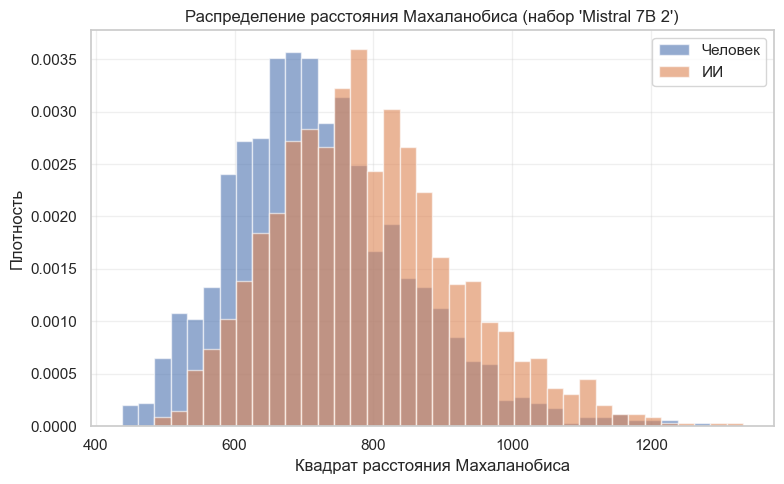

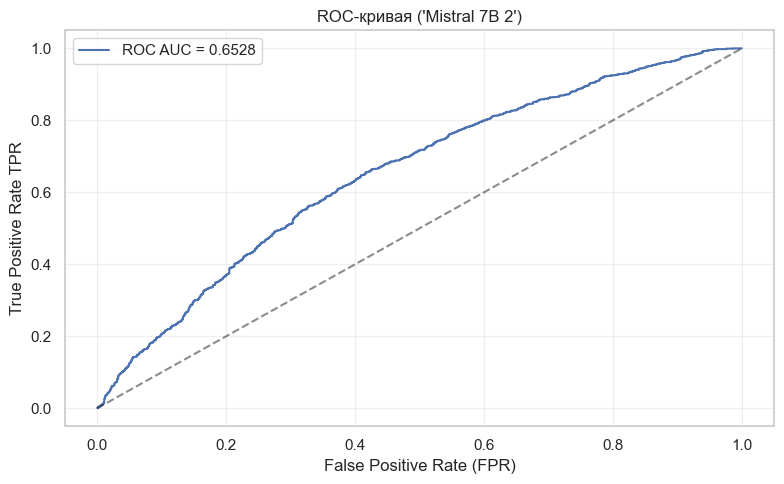

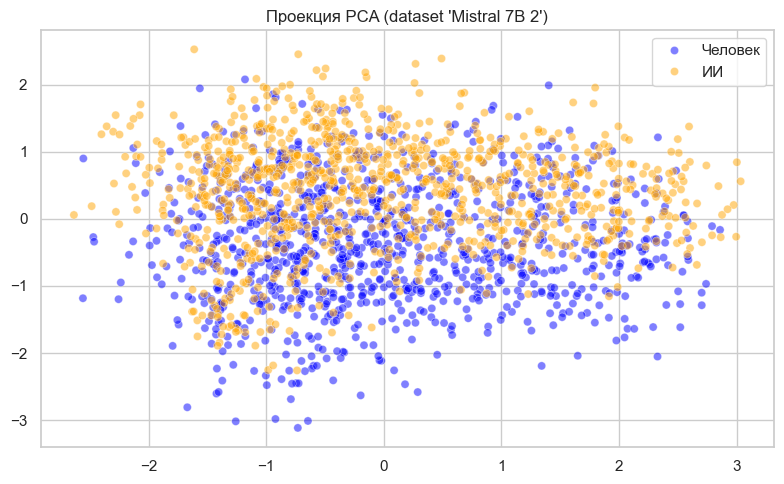


Набор: Mistral 7B 3
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:42<00:00,  2.19it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     723.3742
Стд. отклонение    |                     128.1998
Асимметрия         |                       0.6907
Эксцесс            |                       0.8598
95% квантиль       |                     947.7775
99% квантиль       |                    1118.6089

Статистики расстояния Махаланобиса (ии)
Среднее            |                     807.2240
Стд. отклонение    |                     150.6433
Асимметрия         |                       0.9038
Эксцесс            |                       1.4570
95% квантиль       |                    1088.0162
99% квантиль       |                    1239.5755

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.6654


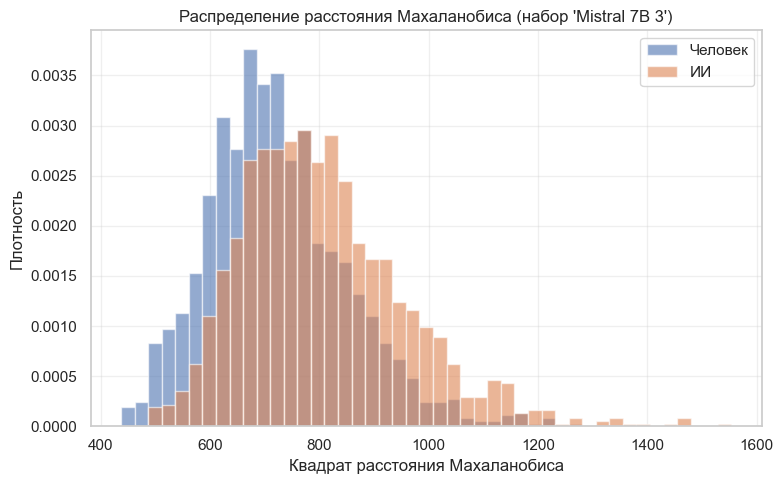

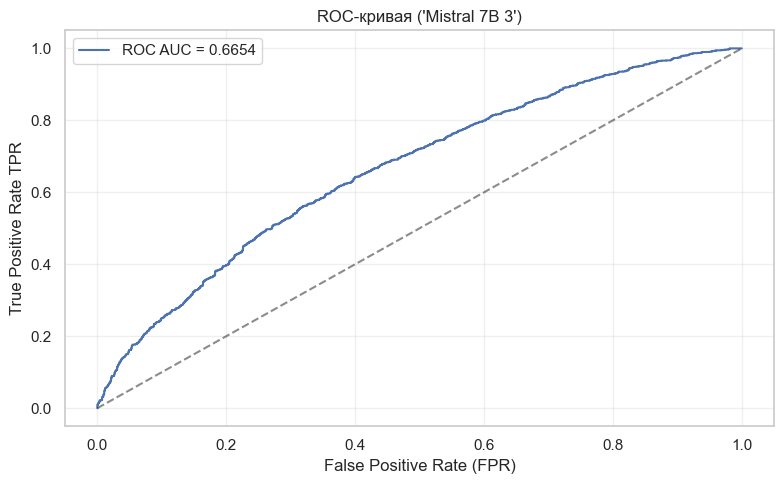

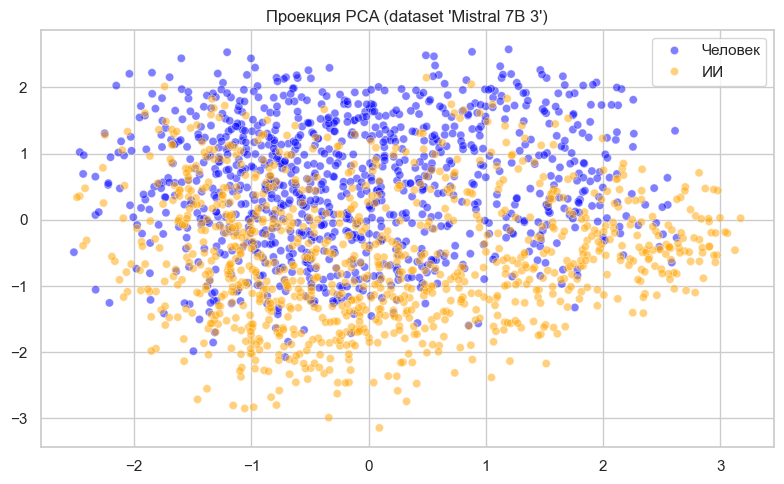


Набор: Mistral 7B 4
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:48<00:00,  1.92it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     723.3742
Стд. отклонение    |                     128.1998
Асимметрия         |                       0.6907
Эксцесс            |                       0.8598
95% квантиль       |                     947.7775
99% квантиль       |                    1118.6089

Статистики расстояния Махаланобиса (ии)
Среднее            |                     794.7532
Стд. отклонение    |                     136.4498
Асимметрия         |                       0.6017
Эксцесс            |                       0.4558
95% квантиль       |                    1042.5040
99% квантиль       |                    1174.1101

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.6535


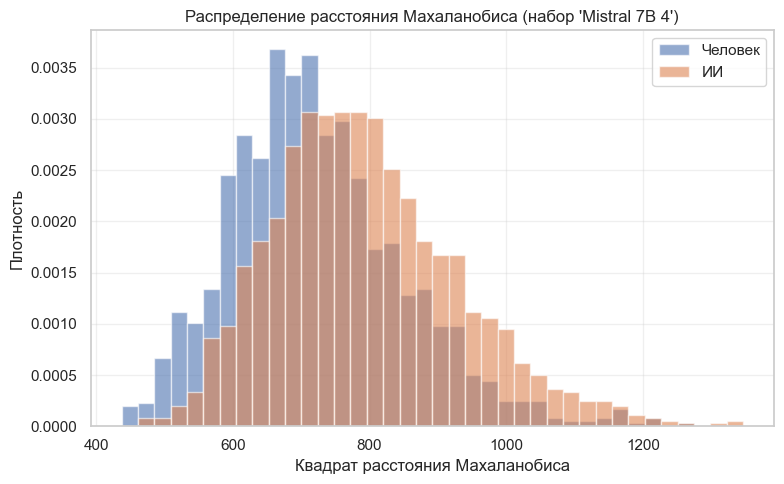

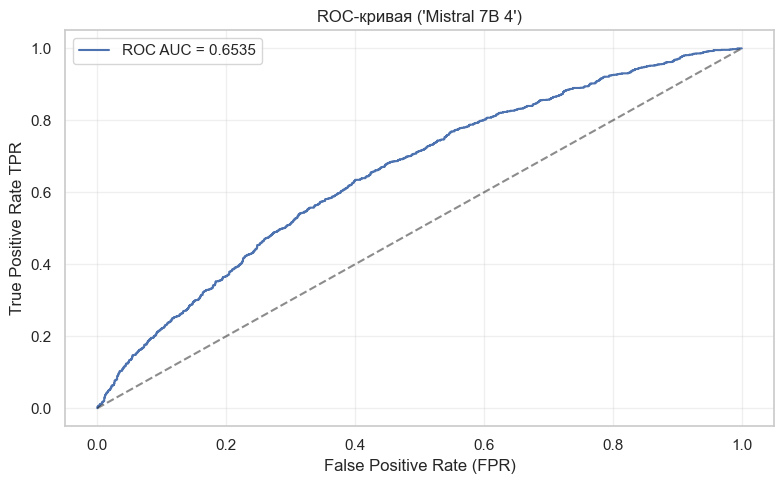

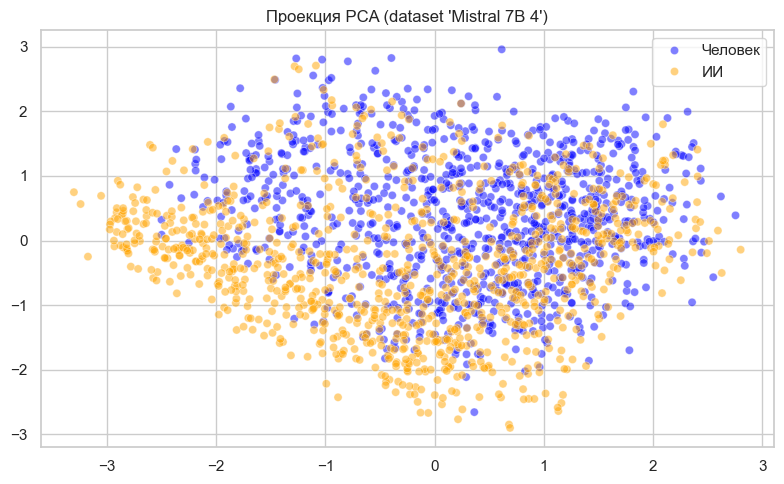


Набор: Mistral 7B 5
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:54<00:00,  1.73it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     723.3742
Стд. отклонение    |                     128.1998
Асимметрия         |                       0.6907
Эксцесс            |                       0.8598
95% квантиль       |                     947.7775
99% квантиль       |                    1118.6089

Статистики расстояния Махаланобиса (ии)
Среднее            |                     774.7793
Стд. отклонение    |                     111.9688
Асимметрия         |                       0.5554
Эксцесс            |                       0.3852
95% квантиль       |                     972.5153
99% квантиль       |                    1079.0458

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.6307


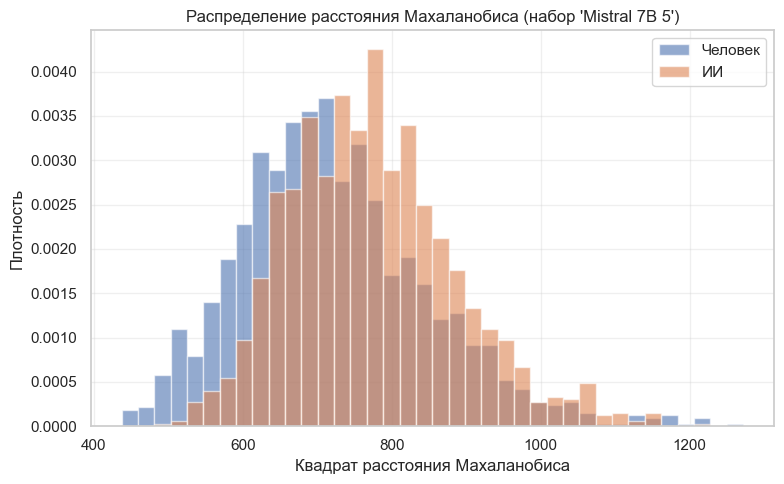

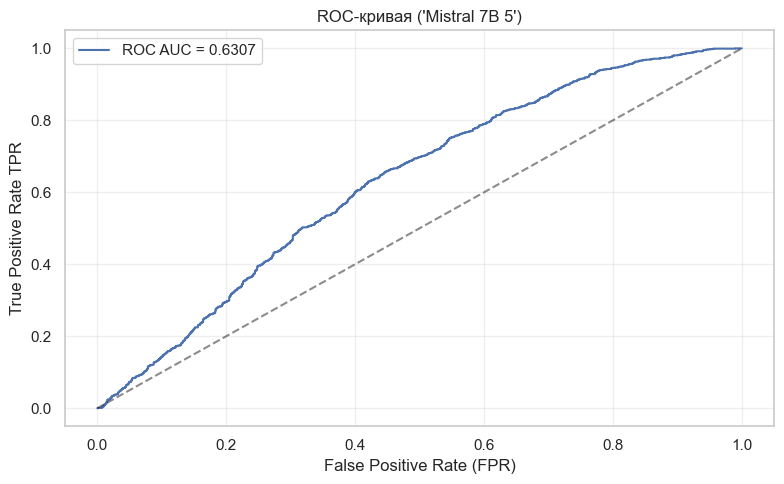

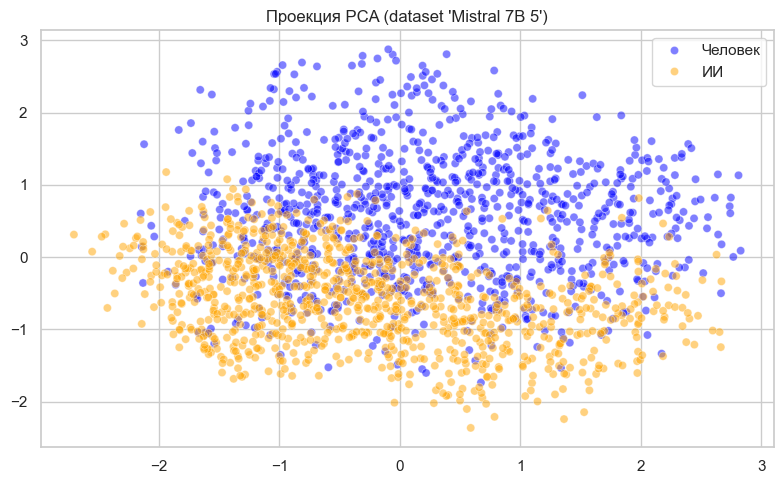


Набор: Llama 3 13B 1
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     724.1279
Стд. отклонение    |                     128.8834
Асимметрия         |                       0.7685
Эксцесс            |                       0.9169
95% квантиль       |                     958.3548
99% квантиль       |                    1120.1292

Статистики расстояния Махаланобиса (ии)
Среднее            |                     880.1359
Стд. отклонение    |                     165.0066
Асимметрия         |                       0.9542
Эксцесс            |                       1.9962
95% квантиль       |                    1185.7787
99% квантиль       |                    1374.4547

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 999
ROC-AUC                            : 0.7819


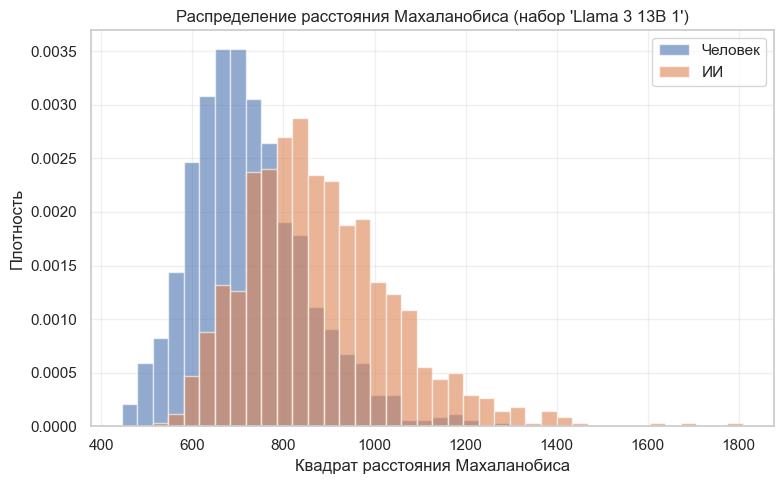

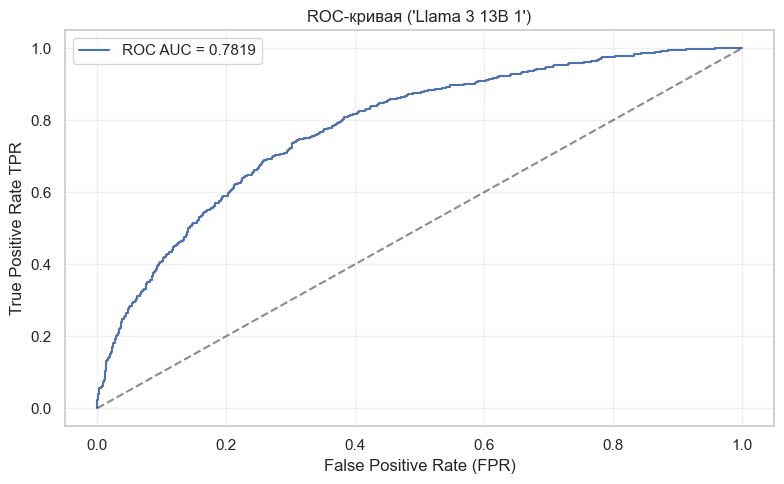

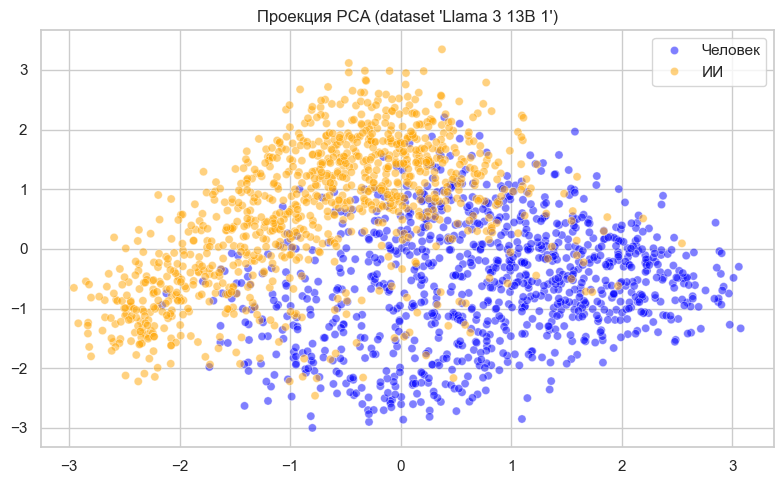


Набор: Llama 3 13B 2
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:36<00:00,  1.72it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     724.0785
Стд. отклонение    |                     128.8283
Асимметрия         |                       0.7698
Эксцесс            |                       0.9209
95% квантиль       |                     958.2827
99% квантиль       |                    1119.9871

Статистики расстояния Махаланобиса (ии)
Среднее            |                     816.0444
Стд. отклонение    |                     131.9609
Асимметрия         |                       0.7457
Эксцесс            |                       0.8949
95% квантиль       |                    1057.7211
99% квантиль       |                    1178.9415

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1000
ROC-AUC                            : 0.7020


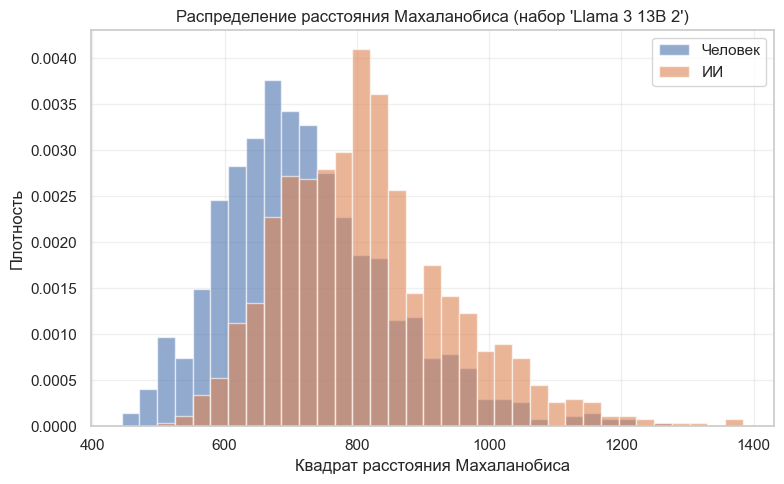

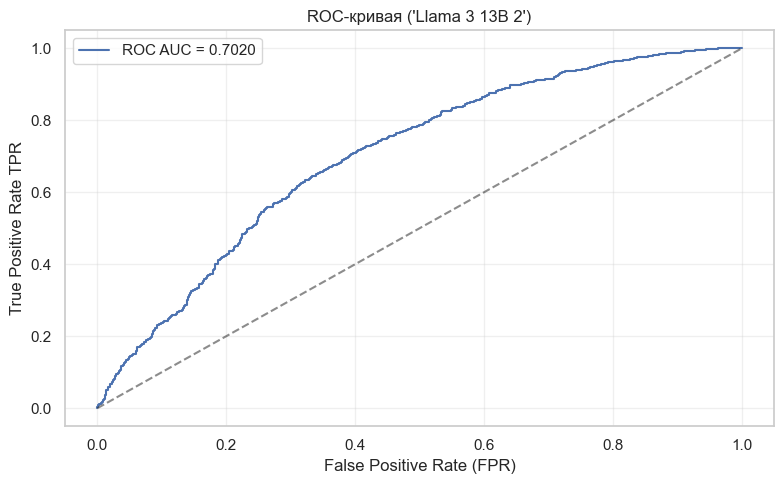

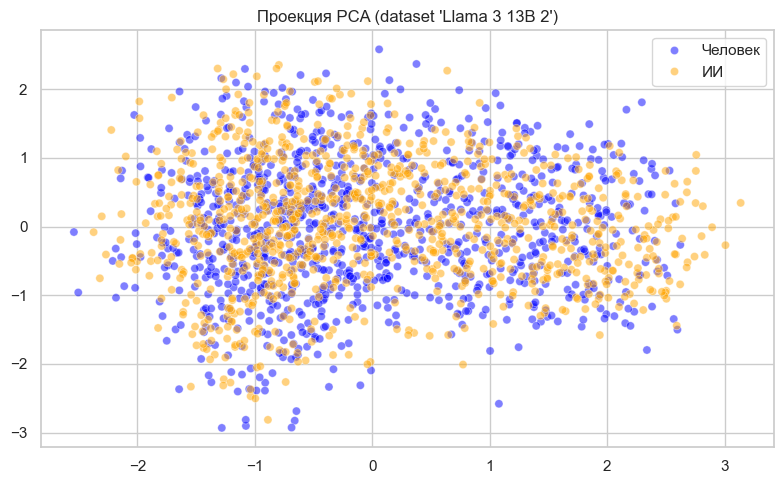


Набор: Llama 3 13B 3
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:36<00:00,  1.72it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     724.3434
Стд. отклонение    |                     129.1066
Асимметрия         |                       0.7639
Эксцесс            |                       0.9038
95% квантиль       |                     958.7156
99% квантиль       |                    1120.8398

Статистики расстояния Махаланобиса (ии)
Среднее            |                     861.0885
Стд. отклонение    |                     172.9339
Асимметрия         |                       1.4751
Эксцесс            |                       6.9433
95% квантиль       |                    1151.0972
99% квантиль       |                    1383.6537

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 994
ROC-AUC                            : 0.7480


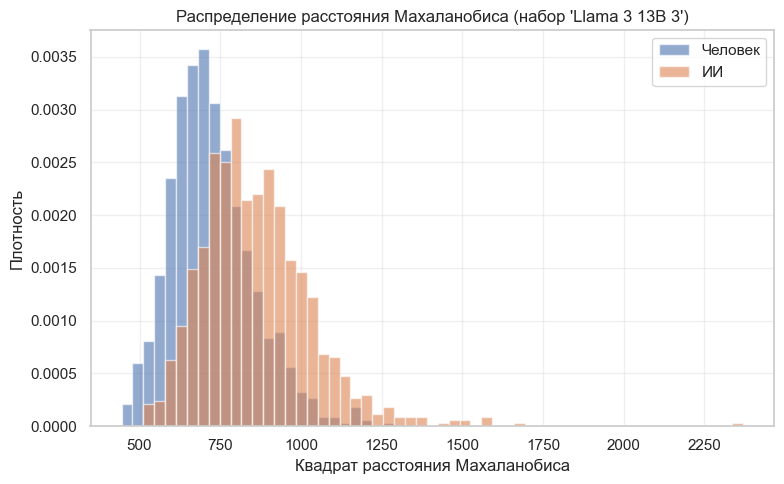

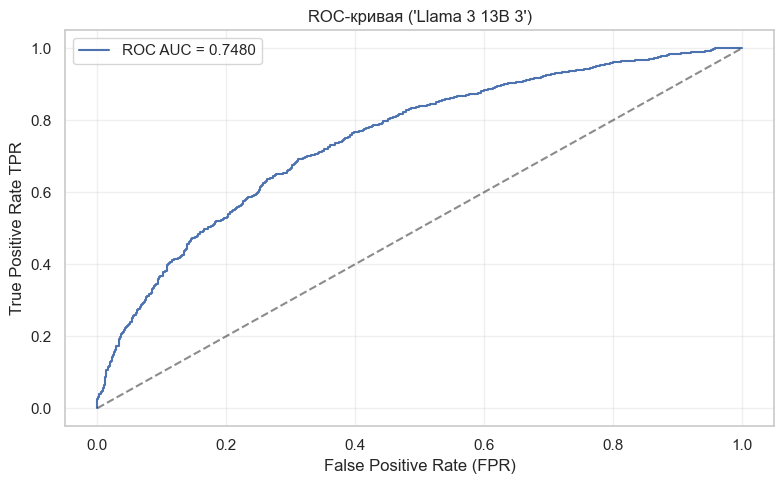

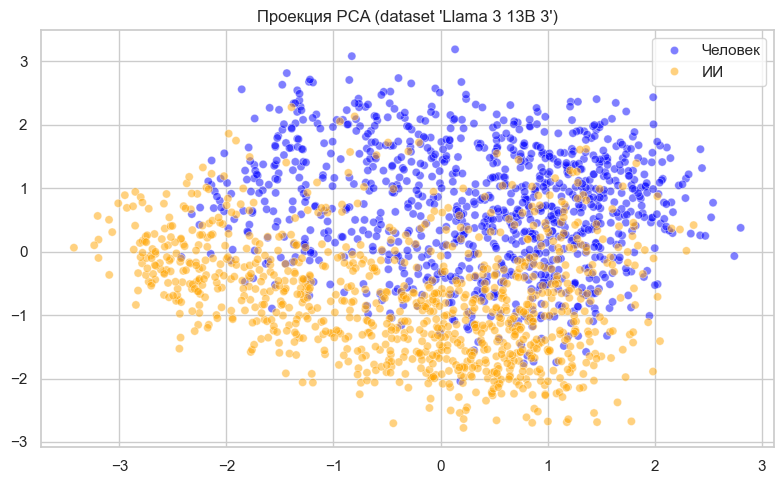


Набор: Llama 3 13B 4
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:36<00:00,  1.72it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     724.1426
Стд. отклонение    |                     128.9649
Асимметрия         |                       0.7684
Эксцесс            |                       0.9142
95% квантиль       |                     958.4992
99% квантиль       |                    1120.4135

Статистики расстояния Махаланобиса (ии)
Среднее            |                     829.2904
Стд. отклонение    |                     150.6245
Асимметрия         |                       0.8483
Эксцесс            |                       1.5060
95% квантиль       |                    1099.1534
99% квантиль       |                    1292.8808

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 997
ROC-AUC                            : 0.7101


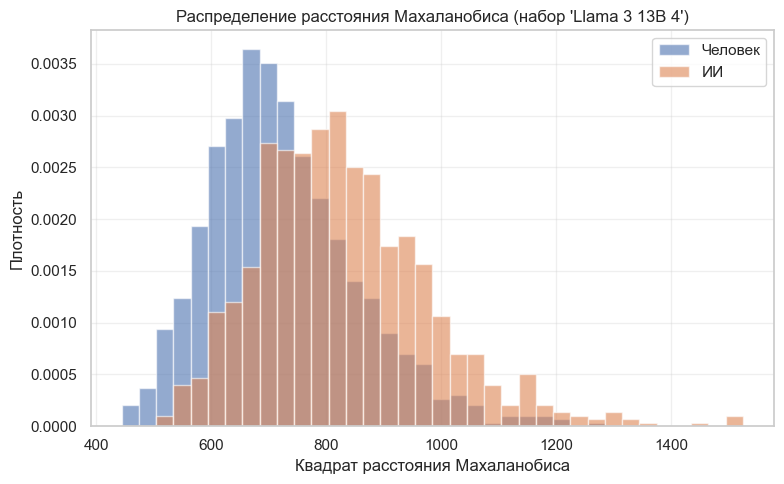

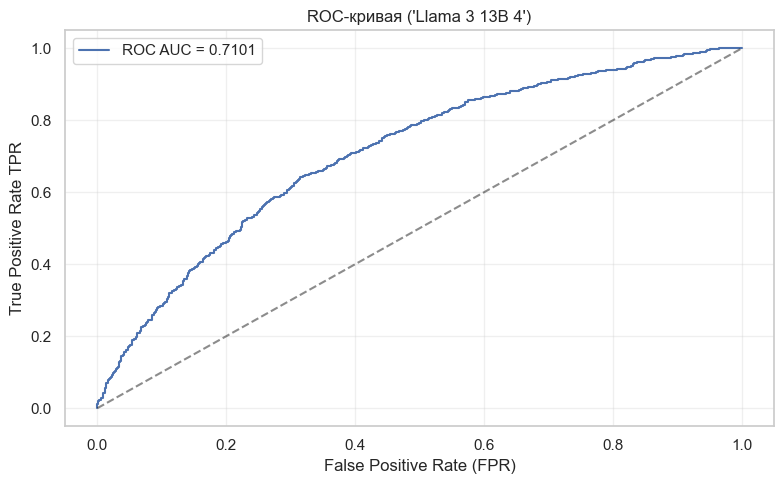

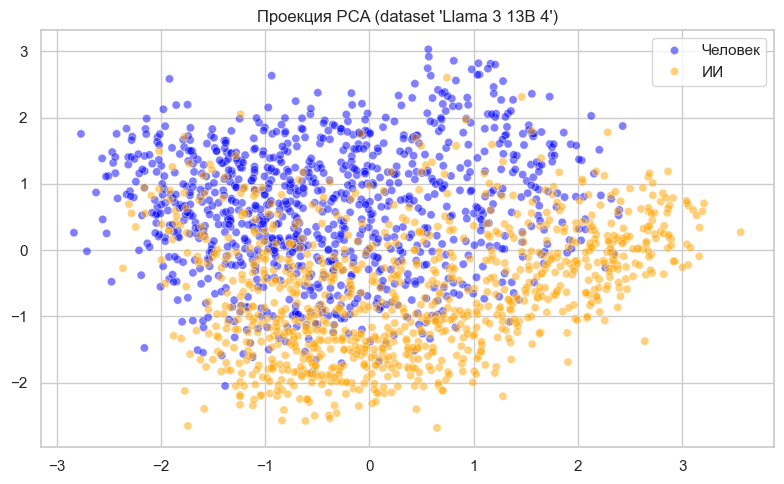


Набор: Llama 3 13B 5
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:37<00:00,  1.66it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     724.1279
Стд. отклонение    |                     128.8834
Асимметрия         |                       0.7685
Эксцесс            |                       0.9169
95% квантиль       |                     958.3548
99% квантиль       |                    1120.1292

Статистики расстояния Махаланобиса (ии)
Среднее            |                     820.0369
Стд. отклонение    |                     143.5194
Асимметрия         |                       3.7057
Эксцесс            |                      45.8944
95% квантиль       |                    1054.0908
99% квантиль       |                    1170.4389

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 999
ROC-AUC                            : 0.7101


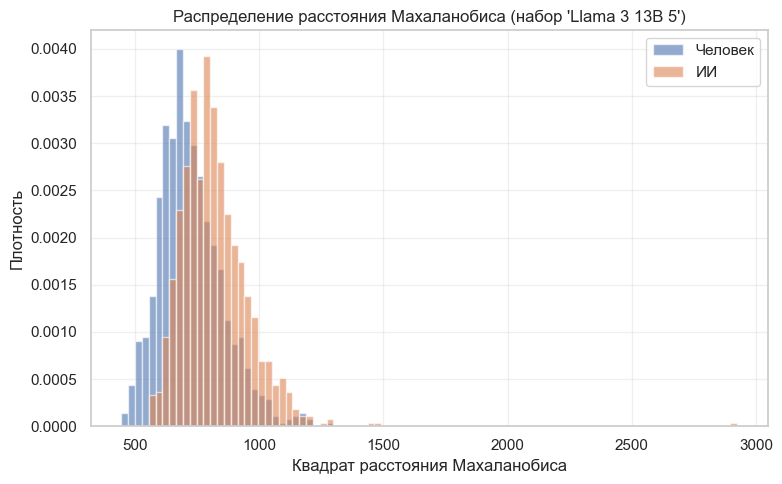

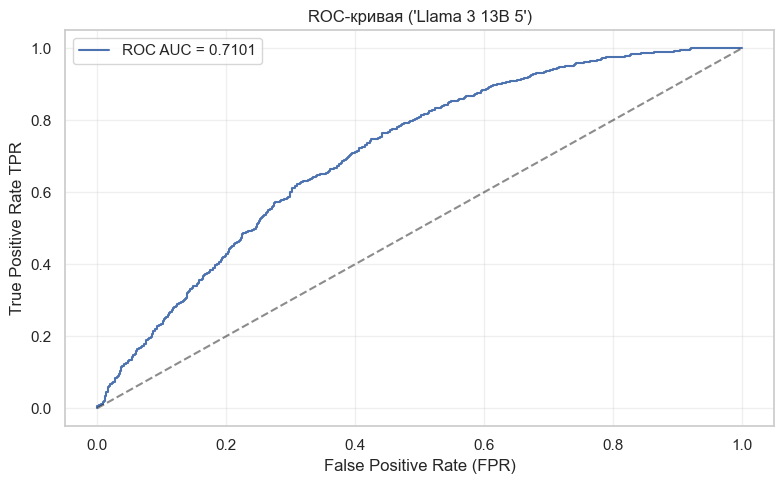

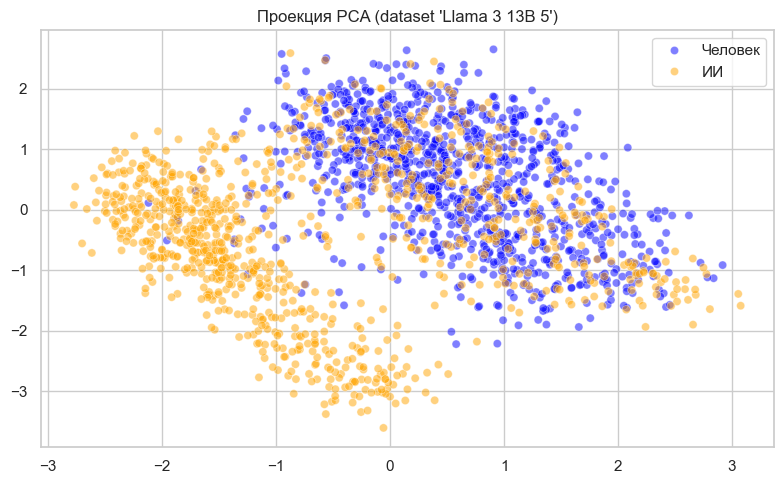


Набор: DeepSeek V3.2 1
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [01:57<00:00,  1.60it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     720.3857
Стд. отклонение    |                     126.7346
Асимметрия         |                       0.7687
Эксцесс            |                       1.7260
95% квантиль       |                     937.2790
99% квантиль       |                    1099.5807

Статистики расстояния Махаланобиса (ии)
Среднее            |                     818.8325
Стд. отклонение    |                     128.2170
Асимметрия         |                       0.9186
Эксцесс            |                       2.0919
95% квантиль       |                    1053.8396
99% квантиль       |                    1191.5253

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 3000
ROC-AUC                            : 0.7189


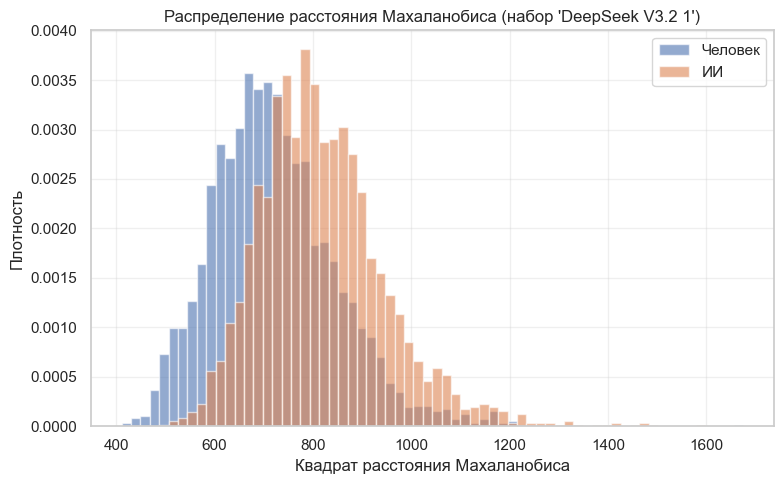

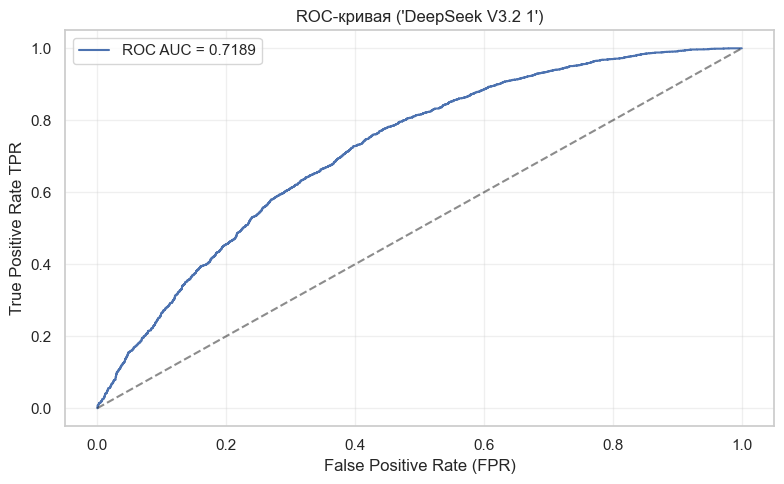

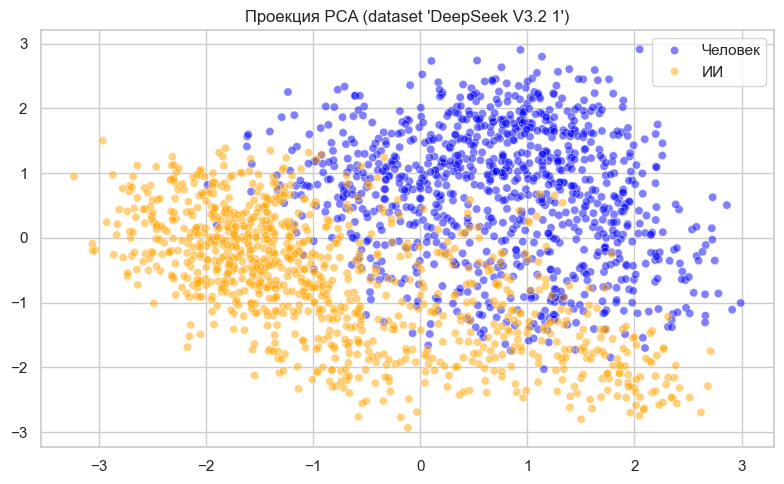


Набор: DeepSeek V3.2 2
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [01:56<00:00,  1.61it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     720.3857
Стд. отклонение    |                     126.7346
Асимметрия         |                       0.7687
Эксцесс            |                       1.7260
95% квантиль       |                     937.2790
99% квантиль       |                    1099.5807

Статистики расстояния Махаланобиса (ии)
Среднее            |                     765.6623
Стд. отклонение    |                     105.9059
Асимметрия         |                       0.5323
Эксцесс            |                       0.5266
95% квантиль       |                     951.7966
99% квантиль       |                    1053.4318

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 3000
ROC-AUC                            : 0.6211


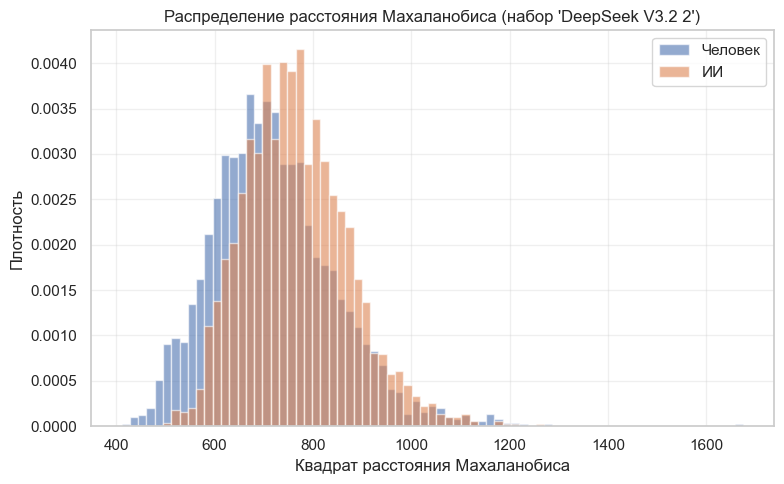

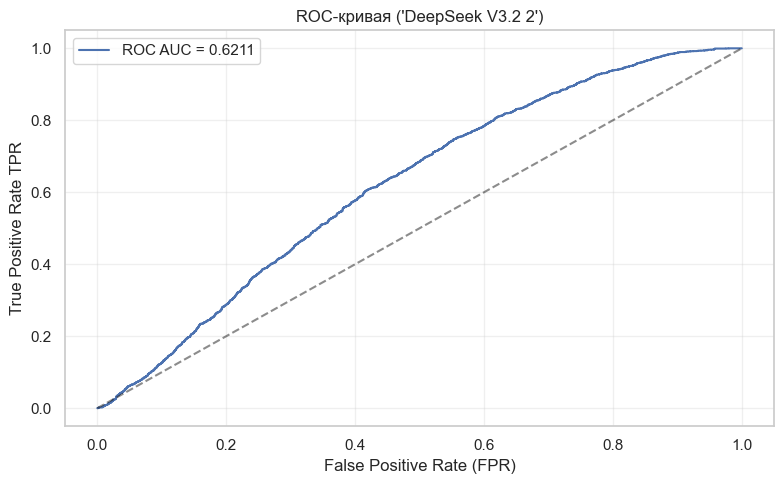

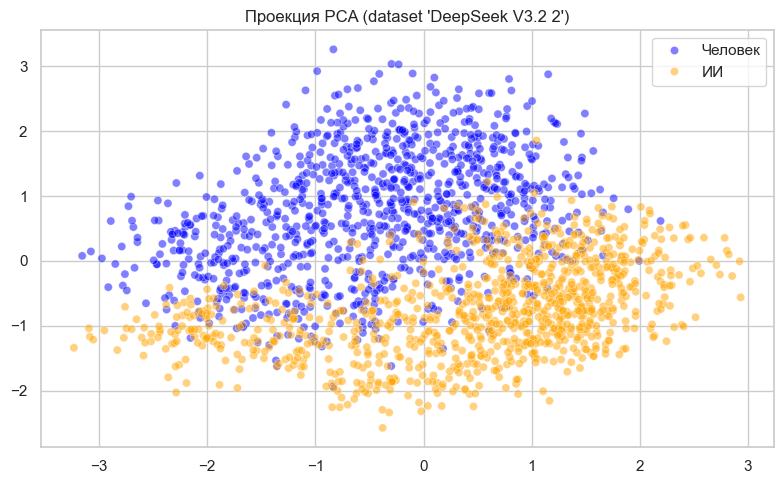


Набор: DeepSeek V3.2 3
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [00:57<00:00,  3.26it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     720.2593
Стд. отклонение    |                     126.5664
Асимметрия         |                       0.7660
Эксцесс            |                       1.7290
95% квантиль       |                     937.1403
99% квантиль       |                    1098.0627

Статистики расстояния Махаланобиса (ии)
Среднее            |                     820.6632
Стд. отклонение    |                     137.9843
Асимметрия         |                       1.0484
Эксцесс            |                       2.6308
95% квантиль       |                    1065.5540
99% квантиль       |                    1248.5596

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2999
ROC-AUC                            : 0.7128


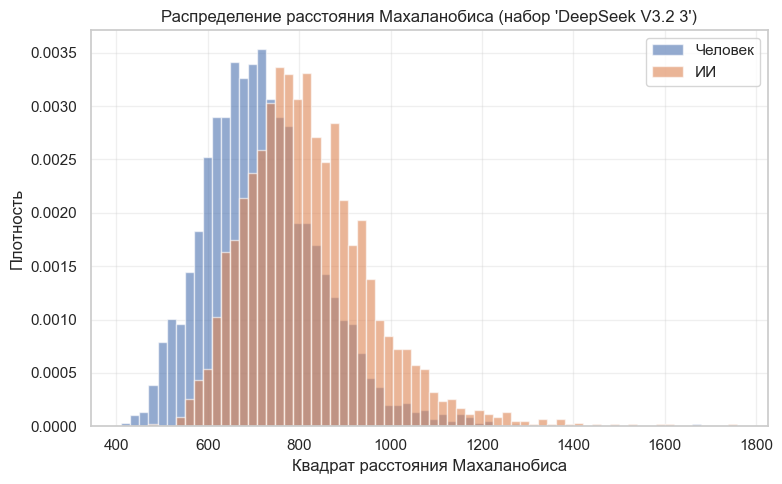

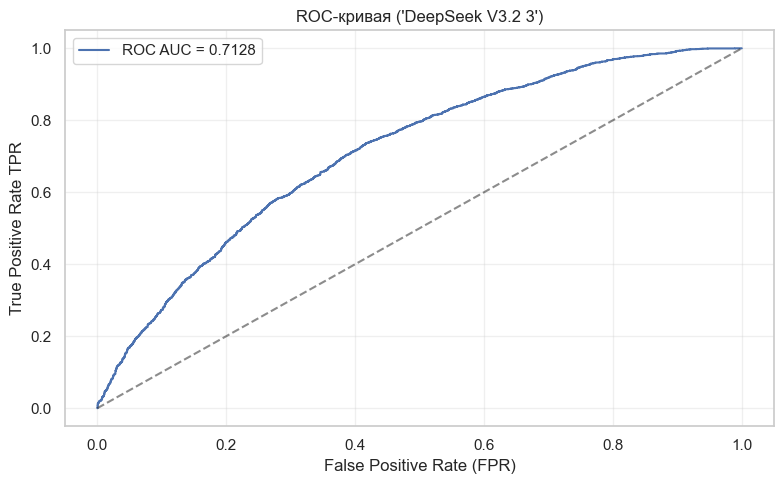

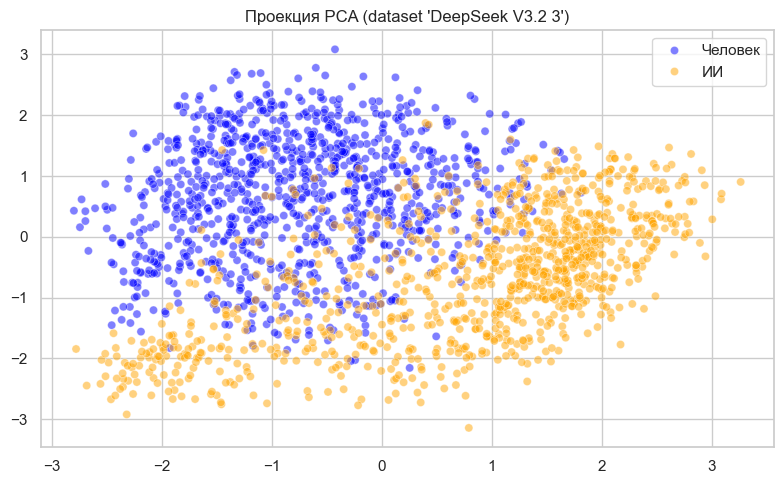


Набор: DeepSeek V3.2 4
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [00:58<00:00,  3.20it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     720.3857
Стд. отклонение    |                     126.7346
Асимметрия         |                       0.7687
Эксцесс            |                       1.7260
95% квантиль       |                     937.2790
99% квантиль       |                    1099.5807

Статистики расстояния Махаланобиса (ии)
Среднее            |                     771.6003
Стд. отклонение    |                     125.2951
Асимметрия         |                       0.8410
Эксцесс            |                       1.6396
95% квантиль       |                     994.1407
99% квантиль       |                    1142.0914

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 3000
ROC-AUC                            : 0.6190


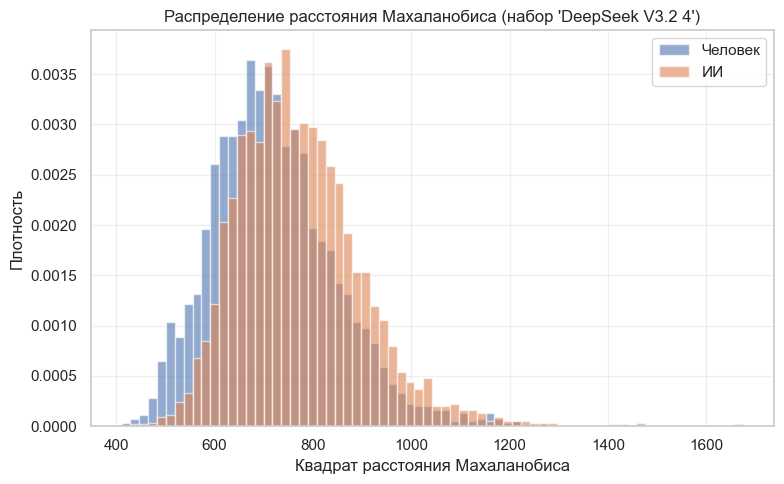

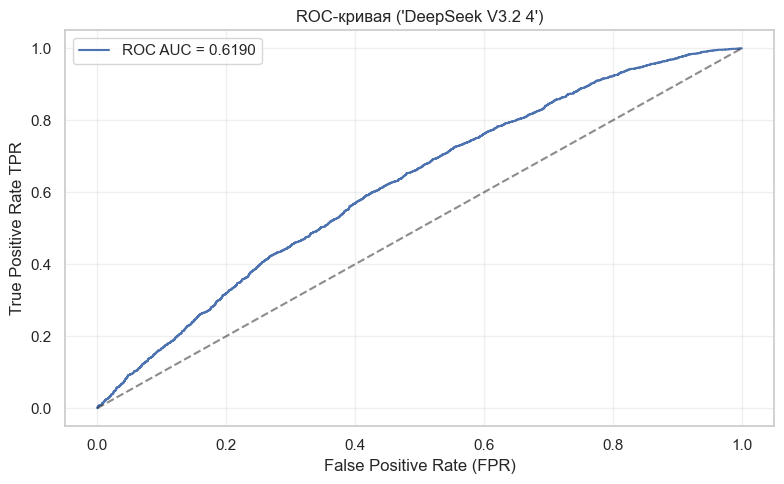

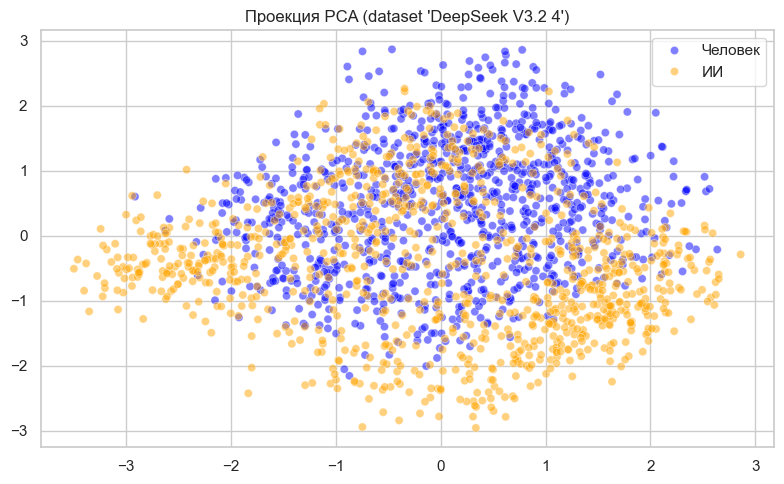


Набор: DeepSeek V3.2 5
----------------------------------------


100%|█████████████████████████████████████████| 157/157 [00:47<00:00,  3.30it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     721.1413
Стд. отклонение    |                     127.3729
Асимметрия         |                       0.7995
Эксцесс            |                       1.8782
95% квантиль       |                     937.8560
99% квантиль       |                    1103.7352

Статистики расстояния Махаланобиса (ии)
Среднее            |                     810.5957
Стд. отклонение    |                     107.4723
Асимметрия         |                       0.5710
Эксцесс            |                       0.6112
95% квантиль       |                     996.7359
99% квантиль       |                    1100.2180

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2500
ROC-AUC                            : 0.7187


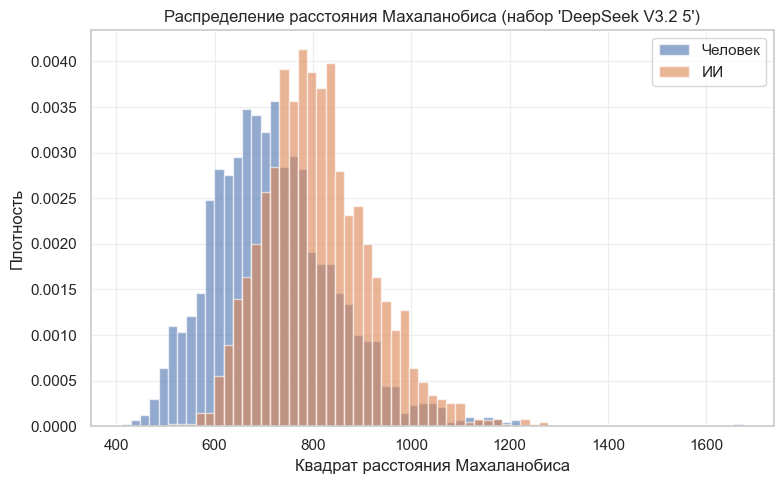

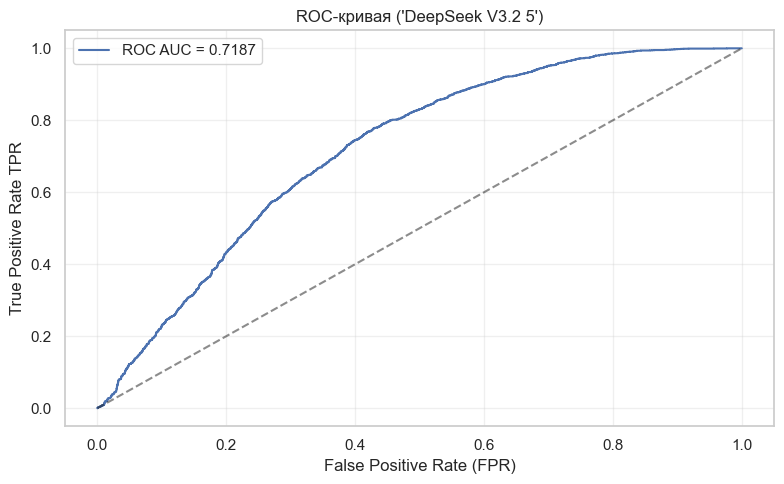

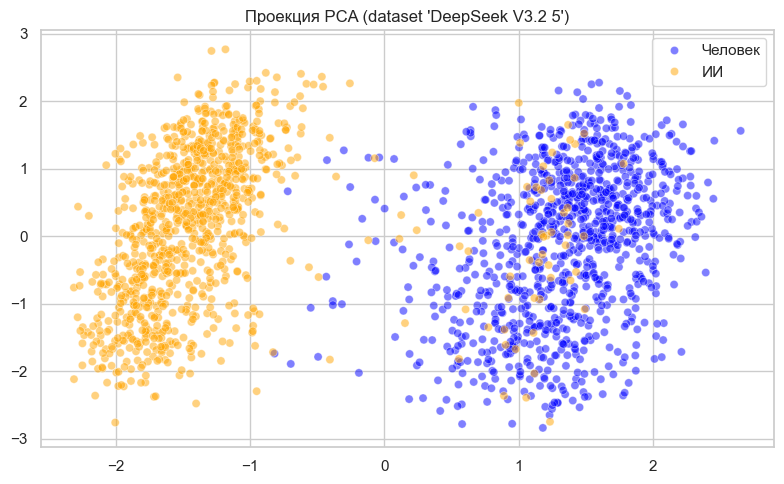


Набор: ChatGPT 1
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:37<00:00,  3.29it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     722.4360
Стд. отклонение    |                     127.6456
Асимметрия         |                       0.7010
Эксцесс            |                       0.8379
95% квантиль       |                     946.5092
99% квантиль       |                    1109.0334

Статистики расстояния Махаланобиса (ии)
Среднее            |                     826.4429
Стд. отклонение    |                     153.9295
Асимметрия         |                       2.7135
Эксцесс            |                      24.6136
95% квантиль       |                    1074.2048
99% квантиль       |                    1264.8521

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.7144


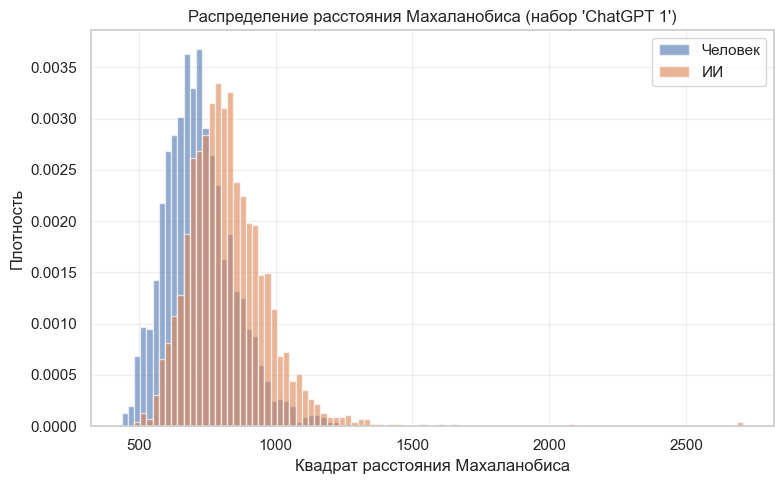

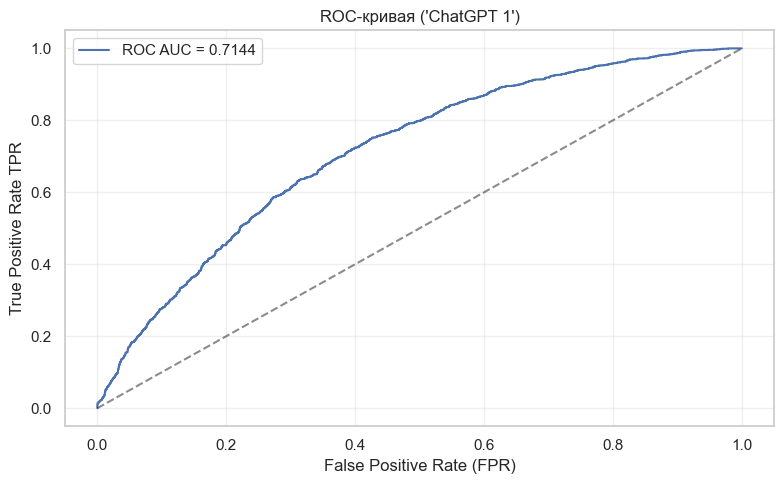

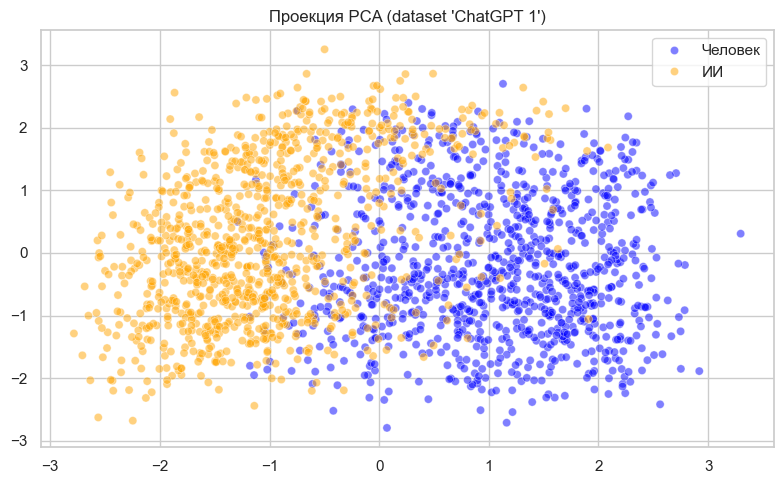


Набор: ChatGPT 2
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:37<00:00,  3.30it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     722.4360
Стд. отклонение    |                     127.6456
Асимметрия         |                       0.7010
Эксцесс            |                       0.8379
95% квантиль       |                     946.5092
99% квантиль       |                    1109.0334

Статистики расстояния Махаланобиса (ии)
Среднее            |                     771.9759
Стд. отклонение    |                     109.6498
Асимметрия         |                       0.5364
Эксцесс            |                       0.4929
95% квантиль       |                     967.9137
99% квантиль       |                    1082.2950

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.6294


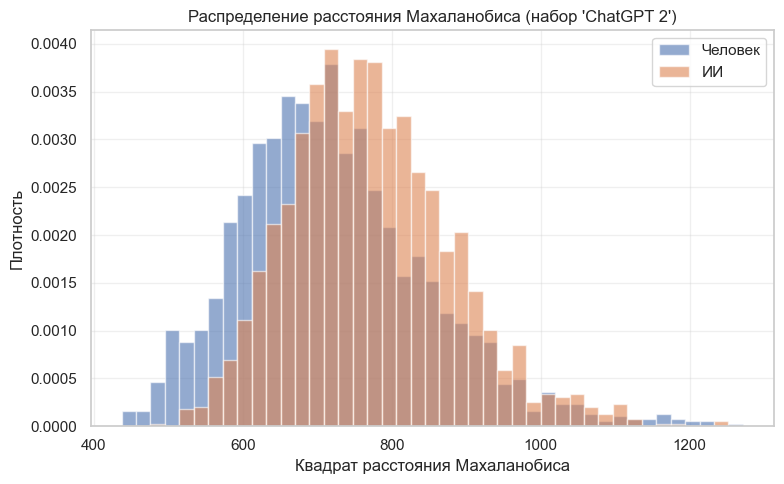

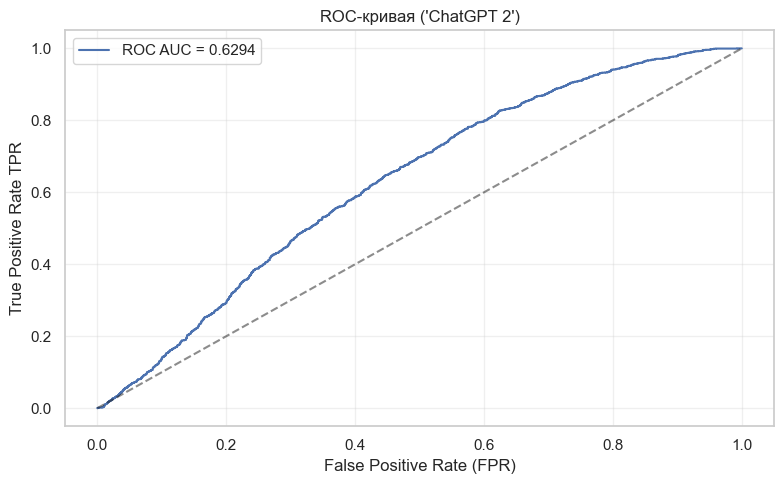

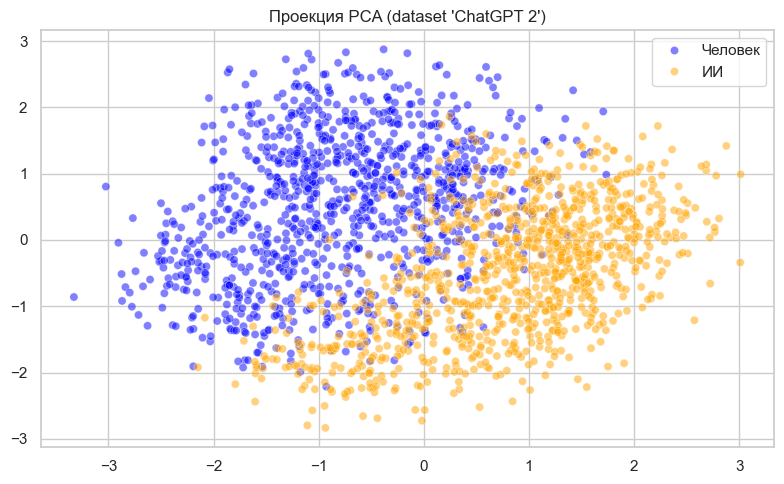


Набор: ChatGPT 3
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:38<00:00,  3.27it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     722.4360
Стд. отклонение    |                     127.6456
Асимметрия         |                       0.7010
Эксцесс            |                       0.8379
95% квантиль       |                     946.5092
99% квантиль       |                    1109.0334

Статистики расстояния Махаланобиса (ии)
Среднее            |                     812.3461
Стд. отклонение    |                     142.3718
Асимметрия         |                       0.9728
Эксцесс            |                       2.4672
95% квантиль       |                    1058.3472
99% квантиль       |                    1250.2053

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.6895


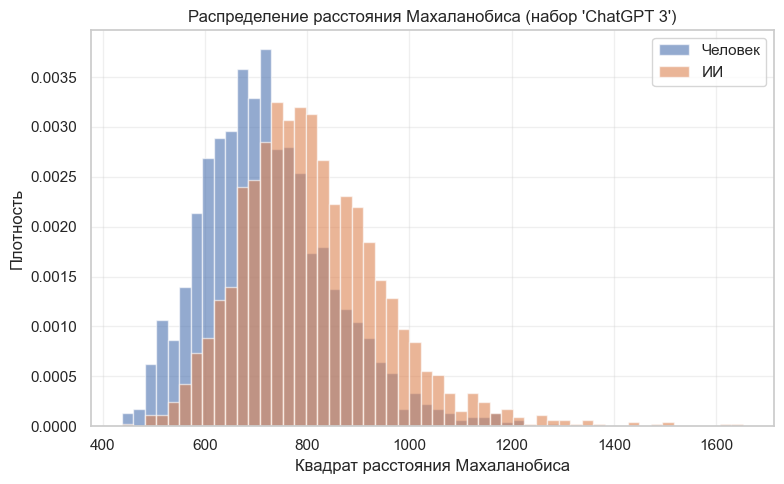

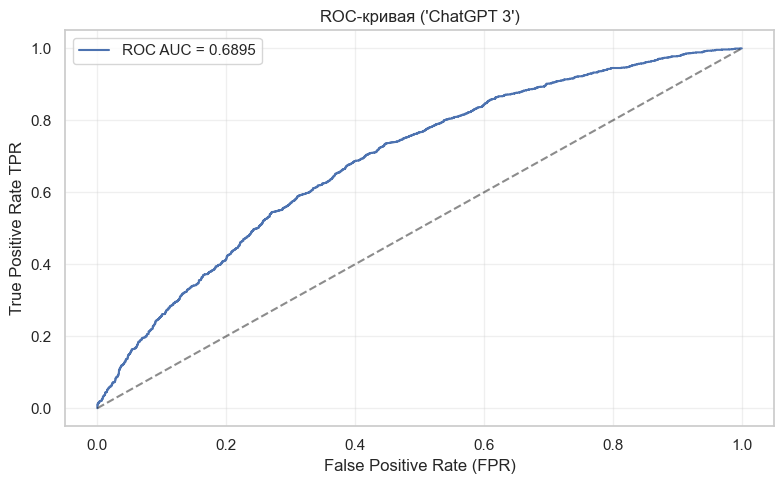

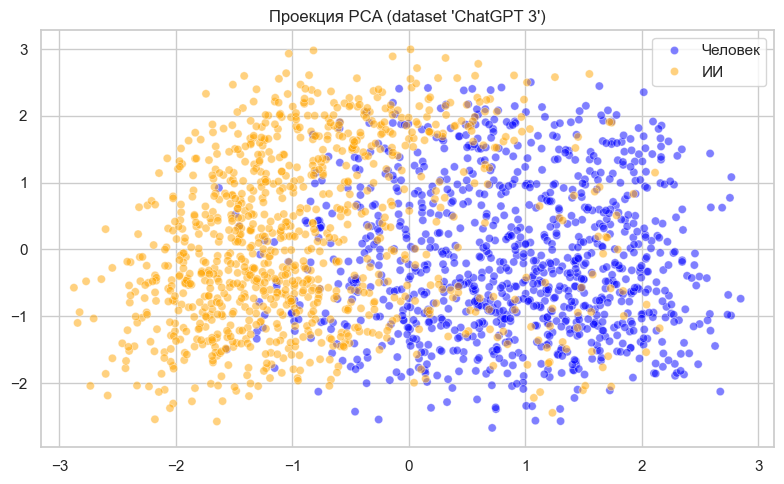


Набор: ChatGPT 4
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:37<00:00,  3.30it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     722.4360
Стд. отклонение    |                     127.6456
Асимметрия         |                       0.7010
Эксцесс            |                       0.8379
95% квантиль       |                     946.5092
99% квантиль       |                    1109.0334

Статистики расстояния Махаланобиса (ии)
Среднее            |                     761.4599
Стд. отклонение    |                     169.8534
Асимметрия         |                       6.6219
Эксцесс            |                     112.7400
95% квантиль       |                     981.3178
99% квантиль       |                    1193.0506

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.5781


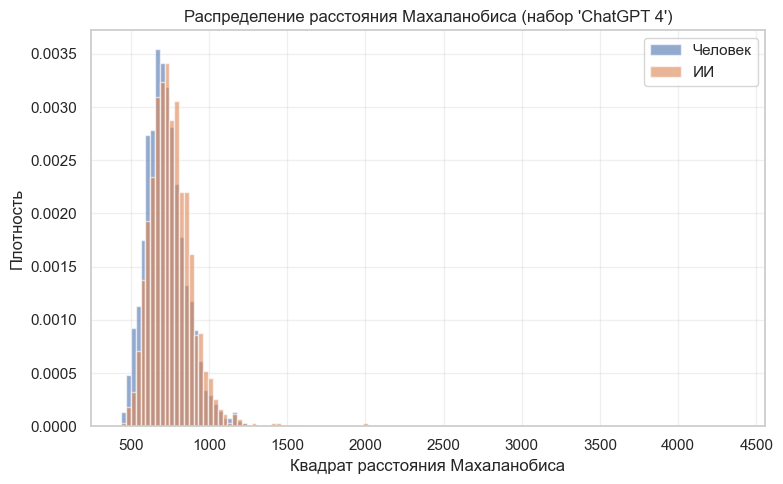

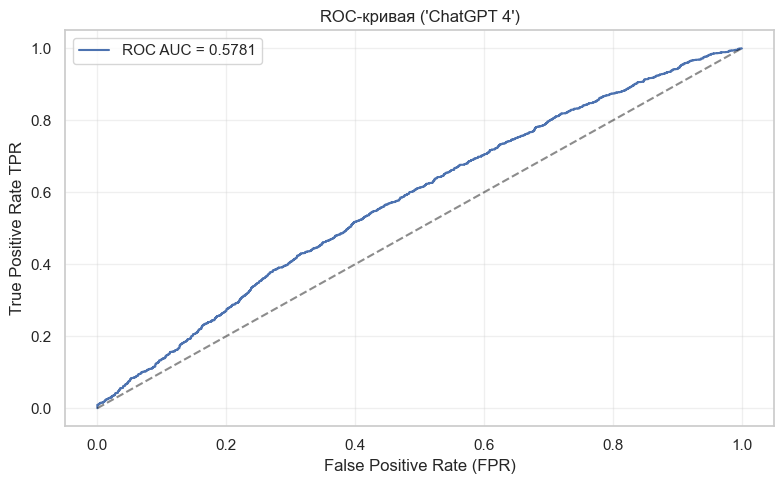

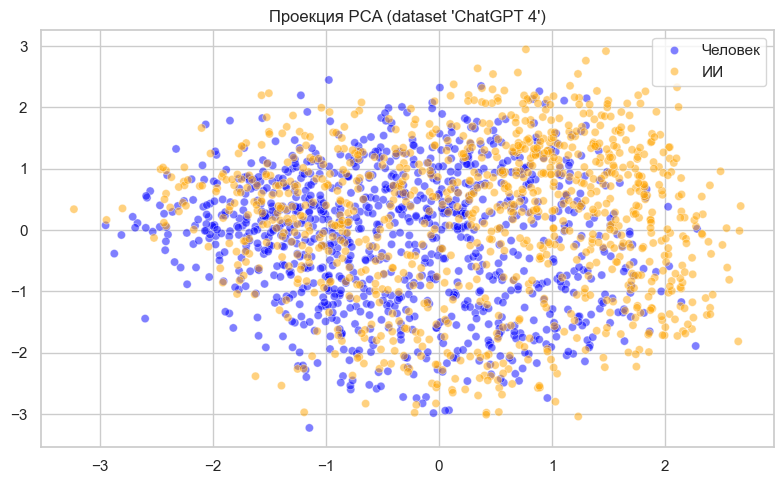


Набор: ChatGPT 5
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:37<00:00,  3.31it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     722.4360
Стд. отклонение    |                     127.6456
Асимметрия         |                       0.7010
Эксцесс            |                       0.8379
95% квантиль       |                     946.5092
99% квантиль       |                    1109.0334

Статистики расстояния Махаланобиса (ии)
Среднее            |                     811.9852
Стд. отклонение    |                     116.4001
Асимметрия         |                       1.0632
Эксцесс            |                       4.7164
95% квантиль       |                    1007.6412
99% квантиль       |                    1115.8776

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.7129


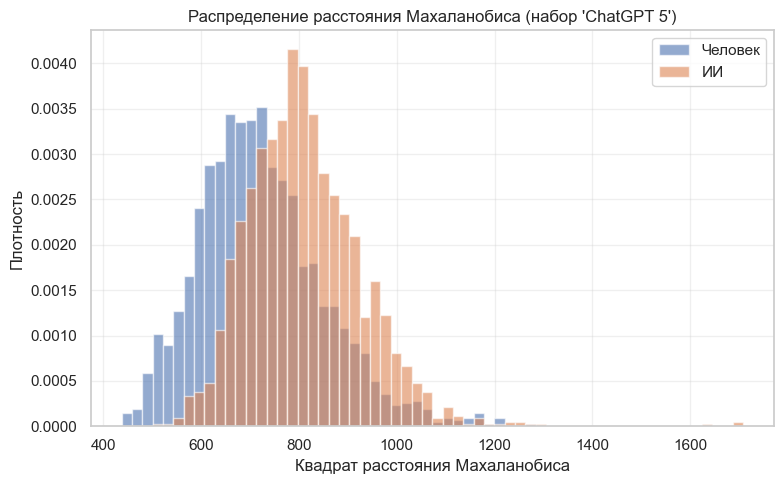

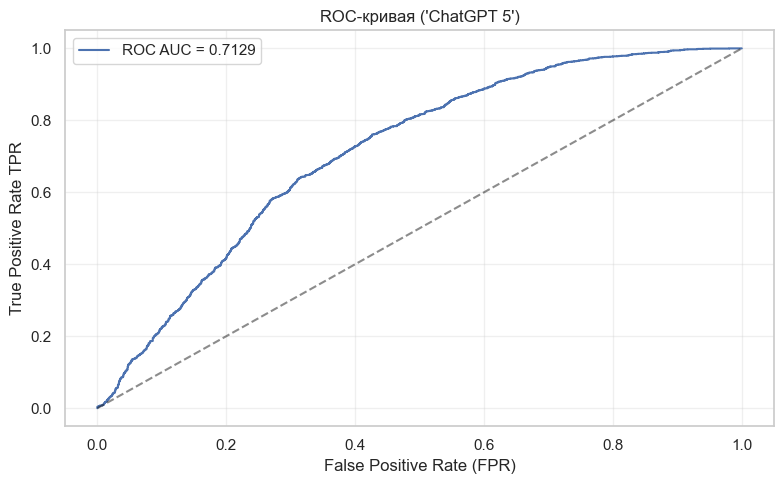

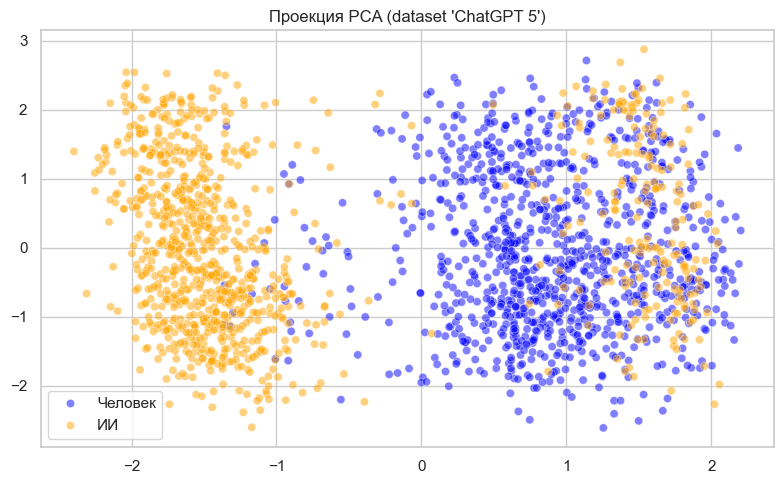

In [7]:
results = []

print_header(f"ENCODER: {ENCODER}")

tokenizer = AutoTokenizer.from_pretrained(ENCODER)
model = AutoModel.from_pretrained(ENCODER)

X_human = get_embeddings(tokenizer, model, human_df["text"])
X_human = X_human.numpy().astype(np.float32)

print_norm_stats(X_human)

X_h_train, X_h_test = train_test_split(
    X_human,
    test_size=0.3,
    random_state=SEED
)

print_kv("Эмбеддинги живых текстов (train)", len(X_h_train))
print_kv("Эмбеддинги живых текстов (test)", len(X_h_test))

cov = LedoitWolf().fit(X_h_train)
scores_h_train = cov.mahalanobis(X_h_train)

covariance_spectrum(cov)

for name, ai_df in ai_datasets.items():
    print(f"\nНабор: {name}")
    print("-" * 40)

    X_ai = get_embeddings(tokenizer, model, ai_df["text"])
    X_ai = X_ai.numpy().astype(np.float32)

    n = min(len(X_h_test), len(X_ai))

    X_test = np.vstack([X_h_test[:n], X_ai[:n]])
    y_test = np.concatenate([
        np.zeros(n, dtype=int),
        np.ones(n, dtype=int)
    ])

    scores = cov.mahalanobis(X_test)
    scores_human = scores[:n]
    scores_ai = scores[n:]

    print_mahalanobis_stats(scores_human, "человек")
    print_mahalanobis_stats(scores_ai, "ии")

    roc_auc = roc_auc_score(y_test, scores)

    print_kv("Количество объектов в 0 классе", len(X_h_test))
    print_kv("Количество объектов в 1 классе", len(X_ai))
    print_kv("ROC-AUC", f"{roc_auc:.4f}")

    plot_mahalanobis_distributions(scores_human, scores_ai, name)
    plot_roc_curve(y_test, scores, roc_auc, name)
    plot_pca_projection(X_h_test, X_ai, name)

    results.append({
        "dataset": name,
        "size": len(X_test),
        "roc_auc": roc_auc,
    })

In [8]:
results_df = pd.DataFrame(results)
print(results_df)

            dataset  size   roc_auc
0      Mistral 7B 1  3000  0.715170
1      Mistral 7B 2  3000  0.652832
2      Mistral 7B 3  3000  0.665378
3      Mistral 7B 4  3000  0.653516
4      Mistral 7B 5  3000  0.630716
5     Llama 3 13B 1  1998  0.781870
6     Llama 3 13B 2  2000  0.702015
7     Llama 3 13B 3  1988  0.748016
8     Llama 3 13B 4  1994  0.710093
9     Llama 3 13B 5  1998  0.710106
10  DeepSeek V3.2 1  6000  0.718897
11  DeepSeek V3.2 2  6000  0.621081
12  DeepSeek V3.2 3  5998  0.712779
13  DeepSeek V3.2 4  6000  0.618995
14  DeepSeek V3.2 5  5000  0.718665
15        ChatGPT 1  4000  0.714431
16        ChatGPT 2  4000  0.629423
17        ChatGPT 3  4000  0.689521
18        ChatGPT 4  4000  0.578059
19        ChatGPT 5  4000  0.712941
